#Object Detection on  Peripheral Blood smear Images

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [2]:
# Mount drive
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [3]:
cd /content/gdrive/Othercomputers/My_Laptop/AI_DataScience_Training/AI_Healthcare/ipython_notebooks/Peripheral_Blood_Smear

/content/gdrive/Othercomputers/My_Laptop/AI_DataScience_Training/AI_Healthcare/ipython_notebooks/Peripheral_Blood_Smear


In [4]:
!ls

detectron2_repo  PBS_data_visualization.ipynb  VOC_BCCD


In [5]:
import cv2

In [5]:
image = cv2.imread('/content/gdrive/Othercomputers/My_Laptop/AI_DataScience_Training/AI_Healthcare/ipython_notebooks/Peripheral_Blood_Smear/VOC_BCCD/JPEGImages/BloodImage_00000_jpg.rf.67c4a4312251eaa52b6ea2f2edf4855b.jpg')

In [6]:
from google.colab.patches import cv2_imshow

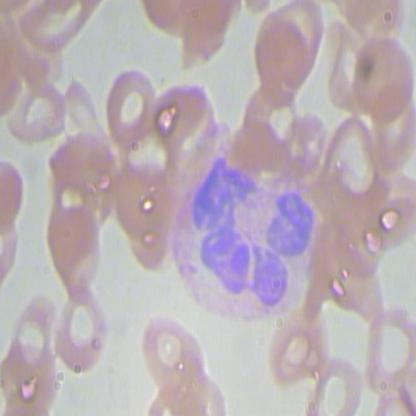

In [7]:
cv2_imshow(image)

In [7]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-ijlucbpk
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-ijlucbpk
     |████████████████████████████████| 636 kB 8.7 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5-py3-none-any.whl size=64542 sha256=50cff7e99954d18528211977d9f51846f1ba1f096afa79332d67352a7a5ca762
  Stored in directory: /tmp/pip-ephem-wheel-cache-l6ld1ev1/wheels/24/1d/09/8167de727fe5b74f832b6fcb5d9069d8f03ca29f337bfe484d
Successfully built fvcore
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


'1.9.0+cu102'

In [8]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

fatal: destination path 'detectron2_repo' already exists and is not an empty directory.
Obtaining file:///content/gdrive/Othercomputers/My_Laptop/AI_DataScience_Training/AI_Healthcare/ipython_notebooks/Peripheral_Blood_Smear/detectron2_repo
     |████████████████████████████████| 74 kB 2.8 MB/s 
     |████████████████████████████████| 145 kB 31.9 MB/s 
     |████████████████████████████████| 130 kB 25.7 MB/s 
     |████████████████████████████████| 743 kB 60.6 MB/s 
     |████████████████████████████████| 745 kB 54.5 MB/s 
     |████████████████████████████████| 112 kB 75.7 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=af4f73ca7635b666d7f0f04420cbac0f77fc41911999c2b210346f50af61e9a4
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully built antlr4-python3-runtime
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
   

In [1]:
# import some common libraries
import numpy as np
import os, json, cv2, random
import skimage.io as io
import pylab
import sys
import copy
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from tensorboard.backend.event_processing import event_accumulator as ea
from PIL import Image


# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Set base params
#plt.rcParams["figure.figsize"] = [16,9]

## **Register Dataset**

Detectron2 keeps track of a list of available datasets in a registry, so we must register our custom data with Detectron2 so it can be invoked for training.

If you want to use a custom dataset while also reusing detectron2’s data loaders, you will need to

Register your dataset (i.e., tell detectron2 how to obtain your dataset).
Optionally, register metadata for your dataset.

In [2]:
dataset_dir = "/content/gdrive/Othercomputers/My_Laptop/AI_DataScience_Training/AI_Healthcare/AI_Healthcare/Peripheral_Blood_Smear/BCCD_COCO"
train_dir = "train/"
val_dir = "valid/"
test_dir = "test/"

In [3]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("bccd_train", {}, os.path.join(dataset_dir,train_dir,"_annotations.coco.json"), os.path.join(dataset_dir,train_dir))
register_coco_instances("bccd_val", {}, os.path.join(dataset_dir,val_dir,"_annotations.coco.json"), os.path.join(dataset_dir,val_dir))
register_coco_instances("bccd_test", {}, os.path.join(dataset_dir,test_dir,"_annotations.coco.json"), os.path.join(dataset_dir,test_dir))

In [4]:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("bccd_train", {}, os.path.join(dataset_dir,train_dir,"_annotations.coco.json"), '/content/gdrive/Othercomputers/My_Laptop/AI_DataScience_Training/AI_Healthcare/AI_Healthcare/Peripheral_Blood_Smear/COCO_BCCD/train')
# register_coco_instances("bccd_val", {}, os.path.join(dataset_dir,val_dir,"_annotations.coco.json"), /content/gdrive/Othercomputers/My_Laptop/AI_DataScience_Training/AI_Healthcare/AI_Healthcare/Peripheral_Blood_Smear/COCO_BCCD/valid')
# register_coco_instances("bccd_test", {}, os.path.join(dataset_dir,test_dir,"_annotations.coco.json"), os.path.join(dataset_dir,test_dir))

In [5]:
dataset_dicts = DatasetCatalog.get("bccd_train")
metadata_dicts = MetadataCatalog.get("bccd_train")

[09/07 16:27:26 d2.data.datasets.coco]: Loading /content/gdrive/Othercomputers/My_Laptop/AI_DataScience_Training/AI_Healthcare/AI_Healthcare/Peripheral_Blood_Smear/BCCD_COCO/train/_annotations.coco.json takes 6.74 seconds.
WARNING [09/07 16:27:26 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/07 16:27:26 d2.data.datasets.coco]: Loaded 765 images in COCO format from /content/gdrive/Othercomputers/My_Laptop/AI_DataScience_Training/AI_Healthcare/AI_Healthcare/Peripheral_Blood_Smear/BCCD_COCO/train/_annotations.coco.json


## **Data Visualization**

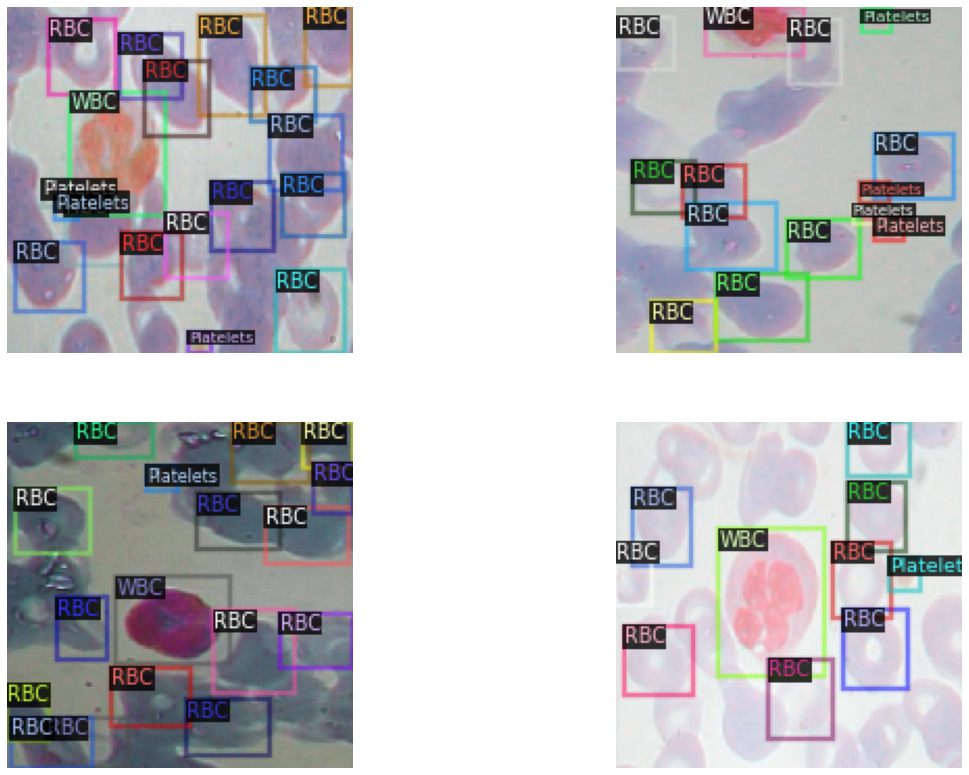

In [6]:
fig, ax = plt.subplots(2, 2, figsize =(20,14))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
for d in random.sample(dataset_dicts, 4):
    i=i+1    
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1],
                   metadata=metadata_dicts, 
                   scale=0.4, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_dataset_dict(d)
    indices[i].grid(False)
    indices[i].axis('off')
    indices[i].imshow(out.get_image()[:, :, ::-1])

## Data Augmentation

In [7]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T

def custom_mapper(dataset_dict):
    
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.Resize((640,640)),
                      T.RandomBrightness(0.9, 1.1),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                      T.RandomCrop("absolute", (640, 640))
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

## Training

In [ ]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" 
#config_name = "COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.DATASETS.TRAIN = ("bccd_train",)
cfg.DATASETS.TEST = ("bccd_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 3500 #adjust up if val mAP is still rising, adjust down if overfit
#cfg.SOLVER.STEPS = (100, 500) # must be less than  MAX_ITER 
#cfg.SOLVER.GAMMA = 0.05


cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


#Training using custom trainer defined above
#trainer = AugTrainer(cfg) 
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[09/07 16:29:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:03, 51.9MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[09/07 16:29:19 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[09/07 16:29:31 d2.utils.events]:  eta: 0:35:04  iter: 19  total_loss: 2.997  loss_cls: 1.753  loss_box_reg: 0.8813  loss_rpn_cls: 0.3014  loss_rpn_loc: 0.07419  time: 0.5921  data_time: 0.2565  lr: 4.9953e-06  max_mem: 3163M
[09/07 16:29:44 d2.utils.events]:  eta: 0:34:51  iter: 39  total_loss: 2.866  loss_cls: 1.645  loss_box_reg: 0.8848  loss_rpn_cls: 0.2567  loss_rpn_loc: 0.06946  time: 0.6096  data_time: 0.2476  lr: 9.9903e-06  max_mem: 3163M
[09/07 16:29:56 d2.utils.events]:  eta: 0:34:49  iter: 59  total_loss: 2.53  loss_cls: 1.435  loss_box_reg: 0.8822  loss_rpn_cls: 0.1649  loss_rpn_loc: 0.06759  time: 0.6139  data_time: 0.2445  lr: 1.4985e-05  max_mem: 3163M
[09/07 16:30:08 d2.utils.events]:  eta: 0:34:37  iter: 79  total_loss: 2.297  loss_cls: 1.196  loss_box_reg: 0.8669  loss_rpn_cls: 0.1543  loss_rpn_loc: 0.06958  time: 0.6134  data_time: 0.2367  lr: 1.998e-05  max_mem: 3163M
[09/07 16:30:21 d2.utils.events]:  eta: 0:34:20  iter: 99  total_loss: 1.967  loss_cls: 0.9513  lo

## Evaluator

In [ ]:
evaluator = COCOEvaluator("bccd_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "bccd_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

In [ ]:
import pandas as pd
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.T

## Predictor

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
cfg.DATASETS.TEST = ("bccd_test", )
predictor = DefaultPredictor(cfg)

In [ ]:
test_dataset_dicts = DatasetCatalog.get("bccd_test")
test_metadata_dicts = MetadataCatalog.get("bccd_test")

In [ ]:
fig, ax = plt.subplots(2, 2, figsize =(20,14))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
for d in random.sample(test_dataset_dicts, 4):
    i=i+1    
    im = io.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata_dicts, 
                   scale=0.4, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    indices[i].grid(False)
    indices[i].imshow(out.get_image()[:, :, ::-1])